In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import random
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import random_split

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [2]:
# helper functions

def readCorrectLab(im_path):
    img = cv2.imread(im_path,-1)
    alpha = img.max()/255 # Contrast control 
    beta = 0 # Brightness control (0-100)
    properImg = cv2.convertScaleAbs(img, alpha=alpha, beta=beta) # convert 0-255 range and to uint8
    return properImg

def randomCropping(img, mask, width=512, height=512):
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    mask = mask[y:y+height, x:x+width]
    return img, mask
    
def central_crop(img, mask, csize=256):
    y,x = img.shape
    startx = x//2 - (csize//2)
    starty = y//2 - (csize//2)
    new_img = img[starty: starty + csize, startx: startx + csize]
    new_mask = mask[starty: starty + csize, startx: startx + csize]
    return new_img,new_mask
    
def padImage(img, mask, minsize=512):
    h, w = img.shape
    if (h < minsize) or (w < minsize):
        padsize_1 = int(abs(minsize - h)) # pad top/bottom
        padsize_2 = int(abs(minsize - w)) # pad left/right
        img_fixed = cv2.copyMakeBorder(img, 0, padsize_1, 0, padsize_2, cv2.BORDER_REFLECT)
        mask_fixed = cv2.copyMakeBorder(mask, 0, padsize_1, 0, padsize_2, cv2.BORDER_REFLECT)
        #img_fixed = cv2.copyMakeBorder(img, 0, padsize_1, 0, padsize_2, cv2.BORDER_CONSTANT, value=0)
        #mask_fixed = cv2.copyMakeBorder(mask, 0, padsize_1, 0, padsize_2, cv2.BORDER_CONSTANT, value=0)
    else:
        img_fixed = img
        mask_fixed = mask
    return img_fixed, mask_fixed

In [3]:
# create dataloader that returns - Image and Target pairs

class NucleiData(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "training_data/rawimages/"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "training_data/groundtruth/"))))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "training_data/rawimages/", self.imgs[idx])
        mask_path = os.path.join(self.root, "training_data/groundtruth/", self.masks[idx])
        #img = Image.open(img_path).convert("RGB") # Pretrained MaskR-CNN uses RGB but if training from scratch we could use Gray
        mask = readCorrectLab(mask_path)
        img = cv2.imread(img_path,0)
        
        img, mask = padImage(img, mask, 512)
        #img, mask = central_crop(img, mask, 256) # other option is to pad all images to a default size
        #img = cv2.resize(img, None, fx=2, fy=2, interpolation = cv2.INTER_NEAREST)
        #mask = cv2.resize(mask, None, fx=2, fy=2, interpolation = cv2.INTER_NEAREST)
        
        # convert numpy to RGB PIL object but the mask var remains the same
        img = Image.fromarray(np.uint8(img)).convert("RGB")
        
        obj_ids = np.unique(mask) # each unique nucleus = a new intensity value 
        obj_ids = obj_ids[1:] # because obj_ids[0] = background 
        masks = mask == obj_ids[:, None, None]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            
            # Check if area is larger than some threshold
            A = abs((xmax-xmin) * (ymax-ymin))
            if A < 5: 
                print('Area smaller than threshold! Box coordinates:', [xmin, ymin, xmax, ymax], ' will be delteted')
                obj_ids=np.delete(obj_ids, [i])
                continue
                
            boxes.append([xmin, ymin, xmax, ymax])
            
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class i.e. the nuclei
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # if all instances are not nuclei
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [4]:
# define model architecture 

def build_model(num_classes): # just finetunng the end layers here
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    #device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = torch.device('cpu')
    
    # use our dataset and defined transformations
    dataset = NucleiData('./', get_transform(train=True))
    
    val_size = 10
    train_size = len(dataset) - val_size
    
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=2, shuffle=True, num_workers=0,
        collate_fn=utils.collate_fn)
    
    #print(len(data_loader))
    
    data_loader_test = torch.utils.data.DataLoader(
        val_ds, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn)
     
    #print(len(data_loader_test))
    
    # our dataset has two classes only - background and person
    num_classes = 2

    # get the model using our helper function
    model = build_model(num_classes)
    # move model to the right device
    model.to(device)


    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0025,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    #lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) # original
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)
    
    
    # number of epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        # evaluate(model, data_loader_test, device=device) # validation part is broken due to numpy inconsitencies, due to lack of time do it manually on 1 image at the end
        if (epoch%2==0):
            torch.save(model, 'trained_model/mask-rcnn-nuclei-epoch-{}.pth'.format(epoch))
            print("Model Saved!")

    print("Finished Training!")

In [5]:
if __name__ == "__main__":
    main()

C:\Users\aakif\anaconda3\envs\ccri_challenge\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
C:\Users\aakif\anaconda3\envs\ccri_challenge\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/39]  eta: 0:10:15  lr: 0.000068  loss: 4.3934 (4.3934)  loss_classifier: 0.8774 (0.8774)  loss_box_reg: 0.6046 (0.6046)  loss_mask: 2.4987 (2.4987)  loss_objectness: 0.2792 (0.2792)  loss_rpn_box_reg: 0.1336 (0.1336)  time: 15.7792  data: 0.1320  max mem: 0
Epoch: [0]  [ 1/39]  eta: 0:08:52  lr: 0.000134  loss: 4.3618 (4.3776)  loss_classifier: 0.8774 (0.9280)  loss_box_reg: 0.2195 (0.4120)  loss_mask: 2.4987 (2.7880)  loss_objectness: 0.0388 (0.1590)  loss_rpn_box_reg: 0.0475 (0.0905)  time: 14.0217  data: 0.1170  max mem: 0
Epoch: [0]  [ 2/39]  eta: 0:08:43  lr: 0.000200  loss: 4.3934 (4.6933)  loss_classifier: 0.8921 (0.9160)  loss_box_reg: 0.5690 (0.4644)  loss_mask: 2.4987 (2.4774)  loss_objectness: 0.2792 (0.6678)  loss_rpn_box_reg: 0.1336 (0.1677)  time: 14.1606  data: 0.1994  max mem: 0
Epoch: [0]  [ 3/39]  eta: 0:08:59  lr: 0.000265  loss: 4.3934 (4.6940)  loss_classifier: 0.8774 (0.8559)  loss_box_reg: 0.5690 (0.5642)  loss_mask: 1.8562 (2.1547)  loss_objectne

In [5]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

In [6]:
# set to evaluation mode
num_classes = 2
model = build_model(num_classes)
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
CLASS_NAMES = ['__background__', 'nuclei']
model.to(device)
model = torch.load('saved_model/mask-rcnn-nuclei-epoch-8.pth')
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [7]:
def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.fromarray(np.uint8(img)).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, label_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    img = cv2.imread(img_path,-1)
    gt_mask = readCorrectLab(label_path)
    print(gt_mask.shape)
    
    img, gt_mask = randomCropInfer(img, gt_mask)
    masks, boxes, pred_cls = get_prediction(img, confidence)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = get_coloured_mask(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        #cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        #cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    
    return img, gt_mask
    
    
def randomCropInfer(img, mask, width=256, height=256):
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width,:]
    mask = mask[y:y+height, x:x+width]
    return img, mask

(914, 1225)


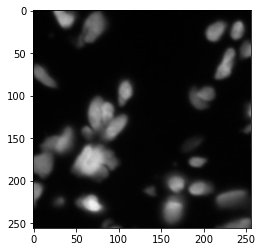

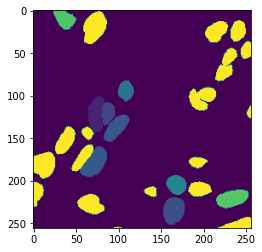

In [8]:
prediction, GT = segment_instance('test/raw/Ganglioneuroblastoma_1.tif', 'test/GT/Ganglioneuroblastoma_1.tif', confidence=0.7)

plt.figure()
plt.imshow(prediction)

plt.figure()
plt.imshow(GT)

In [10]:
plt.imsave('prediction_mrcnn.png',prediction)
plt.imsave('GT_mrcnn.png',GT)